In [1]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

device='cuda'

session = load_training_session(
    save_path='saves/Dec17_CLIP_MSE_delay_0.15/epoch_10',
    studies={"gwilliams2023": 'audio'},
    data_path='data',
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

recording = session.recordings[2]

print(
    f'Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}'
)

dataloader.start_fetching(
    recordings=[
        recording
    ]
)
batch = dataloader.get_recording()
brain, audio, recording = batch.brain_segments['all'].to(device), batch.audio_segments.to(device), batch.recording

conditions = {
    "study": f'{recording.study_name}',
    "subject": f'{recording.study_name}_{recording.subject_id}',
}
session.model.to(device)

with torch.no_grad():
    pred, _ = session.model(
        x=brain, 
        recording=recording, 
        conditions=conditions , 
        train=False
    )
    
dataloader.stop()

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

SimpleConv initialized with 2524704 parameters, cond: []
Merger False, merger channels None
ConvBlocks: 4, hidden_dim: 256, params 2327040


2024-12-18 21:39:38,164	INFO worker.py:1821 -- Started a local Ray instance.


Showing recording: Gwilliams2023_01_2


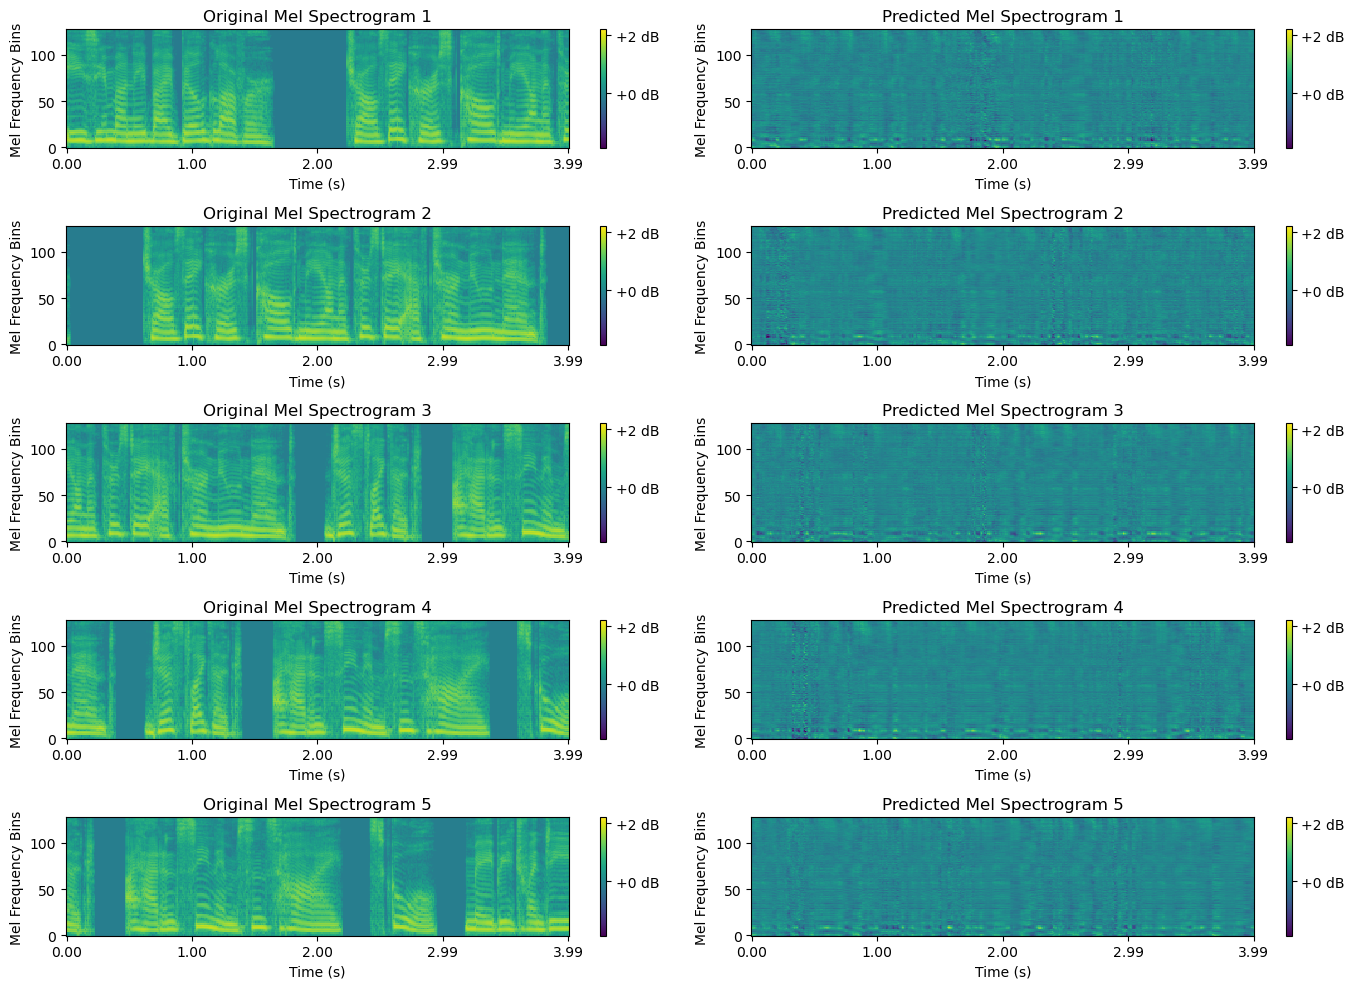

In [2]:
from utils.plot import mel_spectrogram

mel_spectrogram(
    x=audio[:5].to('cpu'),
    max_plots=5,
    x_pred=pred[:5].to('cpu')
)

In [4]:
audio.max(), audio.min(), audio.mean(), pred.max(), pred.min(), pred.mean()

(tensor(1.9548, device='cuda:0'),
 tensor(-0.2490, device='cuda:0'),
 tensor(0.4795, device='cuda:0'),
 tensor(14.1573, device='cuda:0'),
 tensor(-6.8322, device='cuda:0'),
 tensor(0.0054, device='cuda:0'))

In [4]:
# from utils.plot import plot_training_metrics
# plot_training_metrics(session.metrics)